# Gearbox Fault Classification
## Notebook 2 — 1D-CNN Training & Evaluation

**Author:** Bradley Nast  
**Thesis:** An Investigative Study into Gearbox Fault Classification Using a Signal Processing and Deep Learning Framework  
**University:** University of Pretoria, 2024

---

This notebook trains and evaluates a **1D Convolutional Neural Network (1D-CNN)** for gearbox fault classification across four signal domains:

- **Time domain** — raw downsampled vibration signal
- **Frequency domain** — FFT magnitude spectrum
- **Angular domain (COT)** — Computed Order Tracking resampled signal
- **Order domain (COT-Frequency)** — FFT of COT signal

The CNN architecture follows Jing et al. (2017), adapted for 3-class classification:
- **Healthy** (label 0)
- **Cracked Tooth** (label 1)  
- **Worn Teeth** (label 2)

Each domain model is trained over multiple runs across a range of segment lengths (1024–6144) to assess the effect of input data length on classification performance.

---
## 0. Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample
from scipy.fft import fft
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import pickle
import h5py

plt.rcParams.update({
    'figure.dpi': 120,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.size': 11
})

print('Libraries loaded.')
print(f'TensorFlow version: {tf.__version__}')

Libraries loaded.
TensorFlow version: 2.20.0


---
## Part 1 — Preprocessing Pipeline

Raw simulation data at 200 kHz is preprocessed through the following pipeline before CNN input:

1. **Sanitisation** — first second removed to eliminate motor run-up transients
2. **Downsampling** — Butterworth anti-aliasing filter (forward + reverse) then resample
3. **Segmentation** — fixed-length segments extracted from downsampled signal
4. **Data augmentation** — additive Gaussian noise (SNR 0–20 dB) applied per segment
5. **Domain transformation** — time → frequency, COT angular, COT order
6. **Label merging** — constant and varying load cases combined per fault class
7. **Standardisation** — MinMax scaling then StandardScaler applied per split

### 1.1. COT Function

In [5]:
def cot(tach, Fs_tach, ppr, trigger, vibration, Fs_vibration, orders):
    """
    Computed Order Tracking (COT).

    Resamples a vibration signal to the angular domain by interpolating
    a fixed number of points per shaft revolution. Eliminates frequency
    smearing caused by varying shaft speed.

    Parameters
    ----------
    tach        : array — tachometer signal (1D)
    Fs_tach     : float — tachometer sampling frequency [Hz]
    ppr         : int   — pulses per revolution
    trigger     : float — pulse trigger level
    vibration   : array — vibration signal (1D)
    Fs_vibration: float — vibration sampling frequency [Hz]
    orders      : int   — resampled points per revolution

    Returns
    -------
    t_cot   : array — resampled time array
    sig_cot : array — order-tracked vibration signal
    """
    dt_tach     = 1 / Fs_tach
    N_tach      = len(tach)
    t_tach      = np.linspace(0, N_tach * dt_tach, N_tach)

    # Detect pulse indices and extract every PPRth (one per revolution)
    pulse_indices = np.where(tach >= trigger)[0]
    ppr_indices   = pulse_indices[::ppr]

    t_cot, sig_cot = [], []

    for i in range(len(ppr_indices) - 1):
        t_start  = t_tach[ppr_indices[i]]
        t_end    = t_tach[ppr_indices[i + 1]]
        t_order  = np.linspace(t_start, t_end, orders)
        sig_order = np.interp(t_order,
                              np.arange(len(vibration)) / Fs_vibration,
                              vibration)
        t_cot.extend(t_order)
        sig_cot.extend(sig_order)

    return np.array(t_cot), np.array(sig_cot)

### 1.2. Full Preprocessing Pipeline

In [12]:
def preprocess_vibration_data(vibration_data, rotation_data, time_start, time_end,
                               original_sampling_rate, target_sampling_rate,
                               segment_length, target_num_segments,
                               snr_db_lower, snr_db_upper,
                               num_classes=3, random_state=42, overlap=0.0):
    """
    Full preprocessing pipeline for 1D-CNN input.

    Accepts pre-loaded vibration and rotation arrays, downsamples, applies COT,
    segments, augments with Gaussian noise, transforms to four signal domains,
    and merges constant and varying load cases by fault class.

    Parameters
    ----------
    vibration_data         : list  — list of 6 arrays (pinion y-acceleration)
    rotation_data          : list  — list of 6 arrays (pinion angular velocity)
    time_start, time_end   : float — sanitised signal window [s]
    original_sampling_rate : float — simulation sampling rate [Hz]
    target_sampling_rate   : float — downsampled rate [Hz]
    segment_length         : int   — CNN input segment length [samples]
    target_num_segments    : int   — augmented segments per dataset
    snr_db_lower/upper     : float — SNR range for noise augmentation [dB]

    Returns
    -------
    time_segments  : array — time domain segments
    freq_segments  : array — frequency domain segments
    all_labels     : array — class labels
    cot_segments   : array — angular domain (COT) segments
    cotf_segments  : array — order domain (COT-FFT) segments
    cot_labels     : array — class labels (same as all_labels)
    """

    def process_signal(data):
        """Anti-aliasing filter + resample."""
        downsample_factor = original_sampling_rate / target_sampling_rate
        nyquist_freq      = target_sampling_rate / 2
        cutoff_freq       = nyquist_freq * 0.95
        b, a = butter(N=10, Wn=cutoff_freq / (original_sampling_rate / 2), btype='low')
        filtered = filtfilt(b, a, data)
        target_n = int(len(filtered) / downsample_factor)
        return resample(filtered, target_n)

    def cut_signals(signal_data, start_idx, end_idx):
        return signal_data[:, start_idx:end_idx]

    def segment_vibration_data(signal_data, segment_length, overlap=0.5):
        step_size = int(segment_length * (1 - overlap))
        segmented = []
        for data in signal_data:
            n_seg = (len(data) - segment_length) // step_size + 1
            segs  = [data[i * step_size:i * step_size + segment_length]
                     for i in range(n_seg)]
            segmented.append(np.array(segs))
        return segmented

    def augment_segments_with_snr(segments, snr_db_lower, snr_db_upper, target_num):
        """Additive Gaussian noise augmentation to synthetically expand dataset."""
        augmented = []
        n_aug_per = max(1, target_num // len(segments))
        for segment in segments:
            for _ in range(n_aug_per):
                snr_db      = np.random.uniform(snr_db_lower, snr_db_upper)
                snr_linear  = 10 ** (snr_db / 10)
                sig_power   = np.mean(segment ** 2)
                noise_power = sig_power / snr_linear
                noise       = np.sqrt(noise_power) * np.random.randn(*segment.shape)
                augmented.append(segment + noise)
        return np.array(augmented[:target_num])

    def compute_cot_batch(Fs, vibration_signal, angular_velocity,
                          pulses_per_revolution=60, orders=4096):
        """Generate synthetic tachometer from angular velocity and apply COT."""
        num_channels  = vibration_signal.shape[0]
        target_length = vibration_signal.shape[1]
        sig_cots      = []

        for ch in range(num_channels):
            dt                = 1 / Fs
            cumulative_angle  = np.cumsum(angular_velocity[ch] * dt)
            pulse_interval    = 2 * np.pi / pulses_per_revolution
            tachometer_signal = np.zeros_like(angular_velocity[ch])
            pulse_count       = 0

            for i in range(1, len(cumulative_angle)):
                if cumulative_angle[i] >= (pulse_count + 1) * pulse_interval:
                    tachometer_signal[i] = 1
                    pulse_count += 1

            _, sig_cot = cot(
                tach=tachometer_signal, Fs_tach=Fs,
                ppr=pulses_per_revolution, trigger=1,
                vibration=vibration_signal[ch], Fs_vibration=Fs,
                orders=orders
            )
            sig_cot = np.pad(sig_cot,
                             (0, max(0, target_length - len(sig_cot))),
                             'constant')[:target_length]
            sig_cots.append(sig_cot)

        return np.array(sig_cots)

    def transform_to_frequency_domain(segments):
        return np.array([np.abs(fft(seg)) for seg in segments])

    # ── Process each dataset ──────────────────────────────────────────────────
    segmented_vibration, segmented_cot = [], []
    for vib_data, rot_data in zip(vibration_data, rotation_data):
        resampled_vib = process_signal(vib_data)
        resampled_rot = process_signal(rot_data)

        start_idx = int(time_start * target_sampling_rate)
        end_idx   = int(time_end   * target_sampling_rate)

        cut_vib = cut_signals(np.array([resampled_vib]), start_idx, end_idx)
        cut_rot = cut_signals(np.array([resampled_rot]), start_idx, end_idx)
        cut_cot = compute_cot_batch(target_sampling_rate, cut_vib, cut_rot,
                                    pulses_per_revolution=60, orders=4096)

        segmented_vibration.append(
            segment_vibration_data(cut_vib, segment_length, overlap)[0])
        segmented_cot.append(
            segment_vibration_data(cut_cot, segment_length, overlap)[0])

    # ── Augment and transform ─────────────────────────────────────────────────
    all_vib, all_freq, all_cot, all_cotf, all_labels = [], [], [], [], []

    for idx, (vib_seg, cot_seg) in enumerate(zip(segmented_vibration, segmented_cot)):
        aug_vib  = augment_segments_with_snr(vib_seg, snr_db_lower, snr_db_upper,
                                              target_num_segments)
        aug_cot  = augment_segments_with_snr(cot_seg, snr_db_lower, snr_db_upper,
                                              target_num_segments)
        freq_vib = transform_to_frequency_domain(aug_vib)
        freq_cot = transform_to_frequency_domain(aug_cot)

        all_vib.append(aug_vib)
        all_freq.append(freq_vib)
        all_cot.append(aug_cot)
        all_cotf.append(freq_cot)
        all_labels.extend([idx] * len(aug_vib))

    # ── Merge constant + varying load by fault class ──────────────────────────
    merged_vib, merged_freq, merged_cot, merged_cotf, merged_labels = [], [], [], [], []

    for health_state, (c_idx, v_idx) in enumerate([(0, 3), (1, 4), (2, 5)]):
        merged_vib.append( np.concatenate([all_vib[c_idx],  all_vib[v_idx]]))
        merged_freq.append(np.concatenate([all_freq[c_idx], all_freq[v_idx]]))
        merged_cot.append( np.concatenate([all_cot[c_idx],  all_cot[v_idx]]))
        merged_cotf.append(np.concatenate([all_cotf[c_idx], all_cotf[v_idx]]))
        merged_labels.extend(
            [health_state] * (len(all_vib[c_idx]) + len(all_vib[v_idx])))

    return (
        np.concatenate(merged_vib),
        np.concatenate(merged_freq),
        np.array(merged_labels),
        np.concatenate(merged_cot),
        np.concatenate(merged_cotf),
        np.array(merged_labels)
    )

### 1.3. Normalisation & Standardisation

In [7]:
def normalize_and_standardize(X_train, X_val, X_test):
    """
    MinMax scaling followed by StandardScaler.

    Scaler is fit on training data only — applied to val and test
    to prevent data leakage.

    Returns reshaped arrays with channel dimension (n, length, 1)
    for 1D-CNN input.
    """
    scaler     = MinMaxScaler(feature_range=(-1, 1))
    X_tr_s     = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
    X_val_s    = scaler.transform(X_val.reshape(X_val.shape[0], -1))
    X_test_s   = scaler.transform(X_test.reshape(X_test.shape[0], -1))

    standardizer = StandardScaler()
    X_tr_n   = standardizer.fit_transform(X_tr_s).reshape(X_train.shape[0],  X_train.shape[1],  1)
    X_val_n  = standardizer.transform(X_val_s).reshape(X_val.shape[0],    X_val.shape[1],    1)
    X_test_n = standardizer.transform(X_test_s).reshape(X_test.shape[0],   X_test.shape[1],   1)

    return X_tr_n, X_val_n, X_test_n

---
## Part 2 — 1D-CNN Architecture

Architecture from Jing et al. (2017), adapted for 3-class output:

| Layer | Parameters |
|---|---|
| Input | `segment_length` × 1 |
| Conv1D | 10 filters, kernel size 64, ReLU |
| MaxPooling1D | pool size 2 |
| Flatten | — |
| Dense | 30 nodes, ReLU |
| Dense (output) | 3 nodes, Softmax |

**Optimiser:** SGD (lr=0.02, momentum=0.5, decay=0.04)  
**Loss:** Categorical cross-entropy  
**Epochs:** 100, **Batch size:** 50

In [8]:
def build_1d_cnn(input_length, num_classes=3):
    """
    1D-CNN architecture from Jing et al. (2017).

    Single conv + pooling block followed by dense classification.
    ReLU activation chosen for gradient stability (avoids vanishing
    gradients common in sigmoid/tanh for deep networks).

    Parameters
    ----------
    input_length : int — segment length (CNN input size)
    num_classes  : int — number of output classes (default 3)

    Returns
    -------
    model : compiled Keras Sequential model
    """
    model = Sequential([
        Conv1D(filters=10, kernel_size=64, activation='relu',
               input_shape=(input_length, 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(30, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=SGD(learning_rate=0.02, momentum=0.5, decay=0.04),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


def train_and_evaluate_1d_cnn(X_train, y_train, X_val, y_val, X_test, y_test,
                               num_classes=3, epochs=100, batch_size=50,
                               save_path=None):
    """
    Train, evaluate and optionally save a 1D-CNN model.

    Parameters
    ----------
    X_train/val/test : arrays — input data, shape (n, length, 1)
    y_train/val/test : arrays — one-hot encoded labels
    num_classes      : int   — number of output classes
    epochs           : int   — training epochs
    batch_size       : int   — SGD mini-batch size
    save_path        : str   — path to save model (None = don't save)

    Returns
    -------
    history       : Keras History object
    test_accuracy : float — test set classification accuracy
    cm            : array — confusion matrix
    """
    model = build_1d_cnn(X_train.shape[1], num_classes)

    history = model.fit(
        X_train, y_train,
        epochs=epochs, batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=0
    )

    _, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    if save_path:
        model.save(f'{save_path}.h5')

    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    y_true = np.argmax(y_test, axis=1)
    cm     = confusion_matrix(y_true, y_pred)

    return history, test_accuracy, cm

---
## Part 3 — Training Loop

The loop iterates over all segment lengths and all four signal domains. For each combination:
- Data is preprocessed and split 80/10/10 (train/val/test)
- Model is trained and evaluated
- Results stored in `aggregated_metrics` dict for analysis

> ⚠️ **Note:** Running all segment lengths with `NUM_RUNS=10` takes significant time. Set `NUM_RUNS=1` and `SEGMENT_LENGTHS=[4096]` for a quick single-run validation, or run the full loop overnight.

In [9]:
# ── Configuration ─────────────────────────────────────────────────────────────
import h5py

HDF5_PATH = r"C:\Users\Brad\OneDrive\2. Projects\9. DS Porfolio\data-science-portfolio\projects\gearbox-fault-cnn\data\gearbox_data.h5"
FILE_IDS  = ['1_C_H', '2_C_CT', '3_C_WT', '4_V_H', '5_V_CT', '6_V_WT']

# Load data from HDF5
with h5py.File(HDF5_PATH, 'r') as hdf:
    vibration_data = [hdf[ds_id]['Pinion_Y_Acceleration'][:] for ds_id in FILE_IDS]
    rotation_data  = [hdf[ds_id]['Pinion_Angular_Velocity'][:] for ds_id in FILE_IDS]

NUM_RUNS        = 10    # Runs per segment length (set to 1 for quick test)
SEGMENT_LENGTHS = [1024, 2048, 3072, 4096, 5120, 6144]

# Uncomment for quick single-run validation:
# NUM_RUNS        = 1
# SEGMENT_LENGTHS = [4096]

# ── Results container ─────────────────────────────────────────────────────────
domain_names = ['Time Domain', 'Frequency Domain', 'COT', 'COT Frequency']

aggregated_metrics = {
    domain: {
        length: {'test_accuracies': [], 'conf_matrices': [], 'histories': []}
        for length in SEGMENT_LENGTHS
    }
    for domain in domain_names
}

print('Configuration ready.')
print(f'Segment lengths : {SEGMENT_LENGTHS}')
print(f'Runs per length : {NUM_RUNS}')
print(f'Total models    : {len(SEGMENT_LENGTHS) * NUM_RUNS * len(domain_names)}')

Configuration ready.
Segment lengths : [1024, 2048, 3072, 4096, 5120, 6144]
Runs per length : 10
Total models    : 240


In [13]:
# ── Main training loop ────────────────────────────────────────────────────────
for segment_length in SEGMENT_LENGTHS:
    print(f'\n=== Segment length: {segment_length} ===')

    # Preprocess data for this segment length
    (time_segments, freq_segments, all_labels,
     cot_segments, cotf_segments, cot_labels) = preprocess_vibration_data(
        vibration_data=vibration_data,
        rotation_data=rotation_data,
        time_start=1.0, time_end=4.1,
        original_sampling_rate=200000,
        target_sampling_rate=20000,
        segment_length=segment_length,
        target_num_segments=30,
        snr_db_lower=0, snr_db_upper=20
    )

    datasets = {
        'Time Domain'     : (time_segments, all_labels),
        'Frequency Domain': (freq_segments, all_labels),
        'COT'             : (cot_segments,  cot_labels),
        'COT Frequency'   : (cotf_segments, cot_labels)
    }

    for domain_name, (segments, labels) in datasets.items():
        print(f'  Training: {domain_name}...')

        for run in range(NUM_RUNS):
            # Train/val/test split: 80/10/10
            X_train, X_temp, y_train, y_temp = train_test_split(
                segments, labels, test_size=0.2,
                stratify=labels, random_state=42 + run
            )
            X_val, X_test, y_val, y_test = train_test_split(
                X_temp, y_temp, test_size=0.5,
                stratify=y_temp, random_state=42 + run
            )

            # Normalise and standardise
            X_train, X_val, X_test = normalize_and_standardize(X_train, X_val, X_test)

            # One-hot encode labels
            y_train = to_categorical(y_train, num_classes=3)
            y_val   = to_categorical(y_val,   num_classes=3)
            y_test  = to_categorical(y_test,  num_classes=3)

            # Convert to tensors
            X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
            X_val   = tf.convert_to_tensor(X_val,   dtype=tf.float32)
            X_test  = tf.convert_to_tensor(X_test,  dtype=tf.float32)

            # Train and evaluate
            save_path = f'{domain_name.replace(" ", "_")}_seg{segment_length}_run{run+1}'
            history, test_acc, cm = train_and_evaluate_1d_cnn(
                X_train, y_train, X_val, y_val, X_test, y_test,
                save_path=save_path
            )

            aggregated_metrics[domain_name][segment_length]['test_accuracies'].append(test_acc)
            aggregated_metrics[domain_name][segment_length]['conf_matrices'].append(cm)
            aggregated_metrics[domain_name][segment_length]['histories'].append(history.history)

        mean_acc = np.mean(aggregated_metrics[domain_name][segment_length]['test_accuracies'])
        std_acc  = np.std(aggregated_metrics[domain_name][segment_length]['test_accuracies'])
        print(f'    {domain_name}: {mean_acc:.3f} ± {std_acc:.3f}')

print('\nTraining complete.')


=== Segment length: 1024 ===
  Training: Time Domain...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    Time Domain: 0.039 ± 0.043
  Training: Frequency Domain...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    Frequency Domain: 0.711 ± 0.108
  Training: COT...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    COT: 0.433 ± 0.078
  Training: COT Frequency...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    COT Frequency: 0.544 ± 0.069

=== Segment length: 2048 ===
  Training: Time Domain...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    Time Domain: 0.056 ± 0.043
  Training: Frequency Domain...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    Frequency Domain: 0.800 ± 0.079
  Training: COT...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    COT: 0.444 ± 0.163
  Training: COT Frequency...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    COT Frequency: 0.483 ± 0.111

=== Segment length: 3072 ===
  Training: Time Domain...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    Time Domain: 0.008 ± 0.025
  Training: Frequency Domain...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    Frequency Domain: 0.850 ± 0.090
  Training: COT...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    COT: 0.400 ± 0.153
  Training: COT Frequency...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    COT Frequency: 0.700 ± 0.085

=== Segment length: 4096 ===
  Training: Time Domain...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    Time Domain: 0.506 ± 0.104
  Training: Frequency Domain...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    Frequency Domain: 0.906 ± 0.056
  Training: COT...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    COT: 0.967 ± 0.057
  Training: COT Frequency...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    COT Frequency: 0.978 ± 0.027

=== Segment length: 5120 ===
  Training: Time Domain...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    Time Domain: 0.473 ± 0.096
  Training: Frequency Domain...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    Frequency Domain: 0.873 ± 0.076
  Training: COT...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    COT: 0.653 ± 0.115
  Training: COT Frequency...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    COT Frequency: 0.927 ± 0.070

=== Segment length: 6144 ===
  Training: Time Domain...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    Time Domain: 0.639 ± 0.183
  Training: Frequency Domain...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    Frequency Domain: 0.978 ± 0.027
  Training: COT...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    COT: 0.883 ± 0.072
  Training: COT Frequency...


c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Brad\anaconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: U

    COT Frequency: 0.956 ± 0.048

Training complete.


In [14]:
# ── Save results to pickle ────────────────────────────────────────────────────
with open('aggregated_metrics.pkl', 'wb') as f:
    pickle.dump(aggregated_metrics, f)
print('Results saved to aggregated_metrics.pkl')

Results saved to aggregated_metrics.pkl


---
## Part 4 — Results

### 4.1. Accuracy vs. Segment Length

In [15]:
# ── Print accuracy summary table ──────────────────────────────────────────────
print(f'{"Domain":<20}', end='')
for sl in SEGMENT_LENGTHS:
    print(f'{sl:<14}', end='')
print()
print('-' * (20 + 14 * len(SEGMENT_LENGTHS)))

for domain in domain_names:
    print(f'{domain:<20}', end='')
    for sl in SEGMENT_LENGTHS:
        m = aggregated_metrics[domain][sl]
        mean = np.mean(m['test_accuracies'])
        std  = np.std(m['test_accuracies'])
        print(f'{mean:.2f}±{std:.2f}    ', end='')
    print()

Domain              1024          2048          3072          4096          5120          6144          
--------------------------------------------------------------------------------------------------------
Time Domain         0.04±0.04    0.06±0.04    0.01±0.03    0.51±0.10    0.47±0.10    0.64±0.18    
Frequency Domain    0.71±0.11    0.80±0.08    0.85±0.09    0.91±0.06    0.87±0.08    0.98±0.03    
COT                 0.43±0.08    0.44±0.16    0.40±0.15    0.97±0.06    0.65±0.11    0.88±0.07    
COT Frequency       0.54±0.07    0.48±0.11    0.70±0.08    0.98±0.03    0.93±0.07    0.96±0.05    


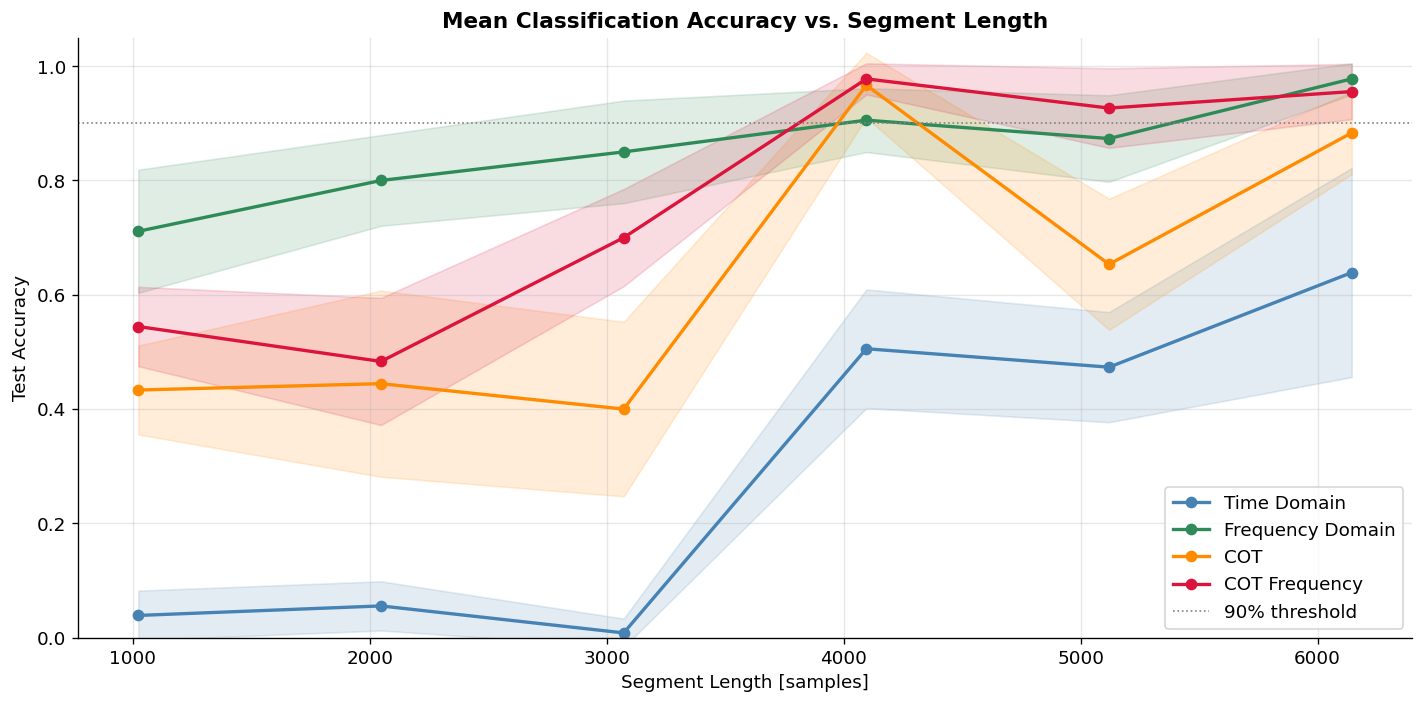

In [16]:
# ── Accuracy vs segment length plot ──────────────────────────────────────────
domain_colors = {
    'Time Domain'     : 'steelblue',
    'Frequency Domain': 'seagreen',
    'COT'             : 'darkorange',
    'COT Frequency'   : 'crimson'
}

plt.figure(figsize=(12, 6))
for domain in domain_names:
    sls        = SEGMENT_LENGTHS
    means      = [np.mean(aggregated_metrics[domain][sl]['test_accuracies']) for sl in sls]
    stds       = [np.std(aggregated_metrics[domain][sl]['test_accuracies'])  for sl in sls]
    color      = domain_colors[domain]
    plt.plot(sls, means, 'o-', color=color, label=domain, lw=2)
    plt.fill_between(sls,
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.15, color=color)

plt.axhline(0.9, color='gray', ls=':', lw=1, label='90% threshold')
plt.title('Mean Classification Accuracy vs. Segment Length',
          fontsize=13, fontweight='bold')
plt.xlabel('Segment Length [samples]')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

### 4.2. Confusion Matrices (4096 Segment Length)

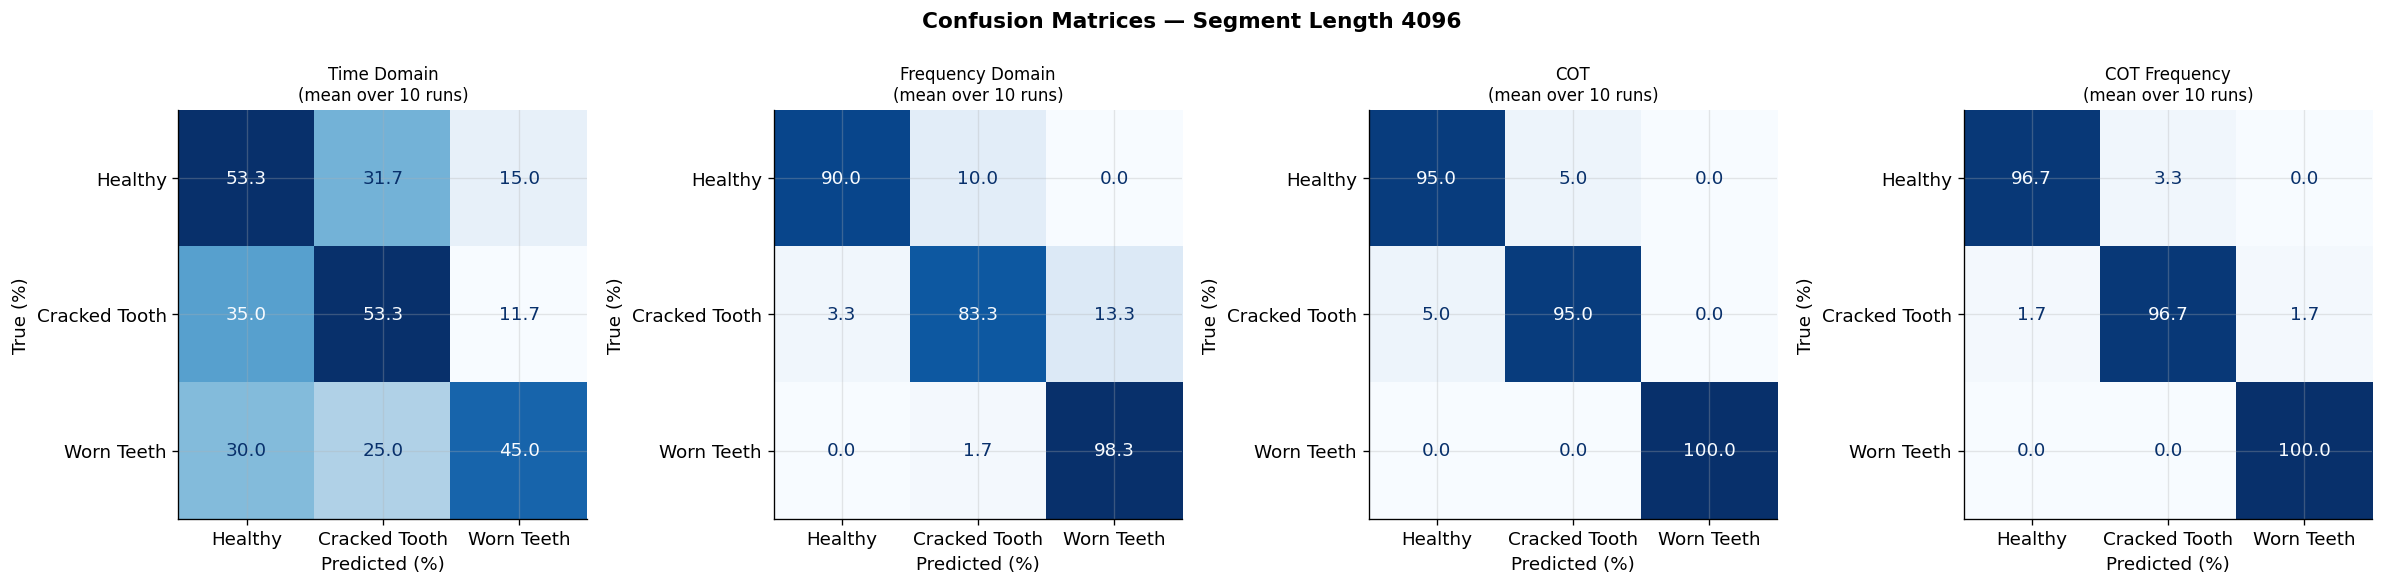

In [17]:
TARGET_SEGMENT = 4096
class_names    = ['Healthy', 'Cracked Tooth', 'Worn Teeth']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, domain in zip(axes, domain_names):
    cms      = aggregated_metrics[domain][TARGET_SEGMENT]['conf_matrices']
    avg_cm   = np.mean(cms, axis=0)
    norm_cm  = avg_cm / avg_cm.sum(axis=1, keepdims=True) * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=norm_cm,
                                  display_labels=class_names)
    disp.plot(cmap='Blues', ax=ax, values_format='.1f', colorbar=False)
    ax.set_title(f'{domain}\n(mean over {len(cms)} runs)', fontsize=10)
    ax.set_xlabel('Predicted (%)')
    ax.set_ylabel('True (%)')

plt.suptitle(f'Confusion Matrices — Segment Length {TARGET_SEGMENT}',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.3. Training History (4096 Segment Length)

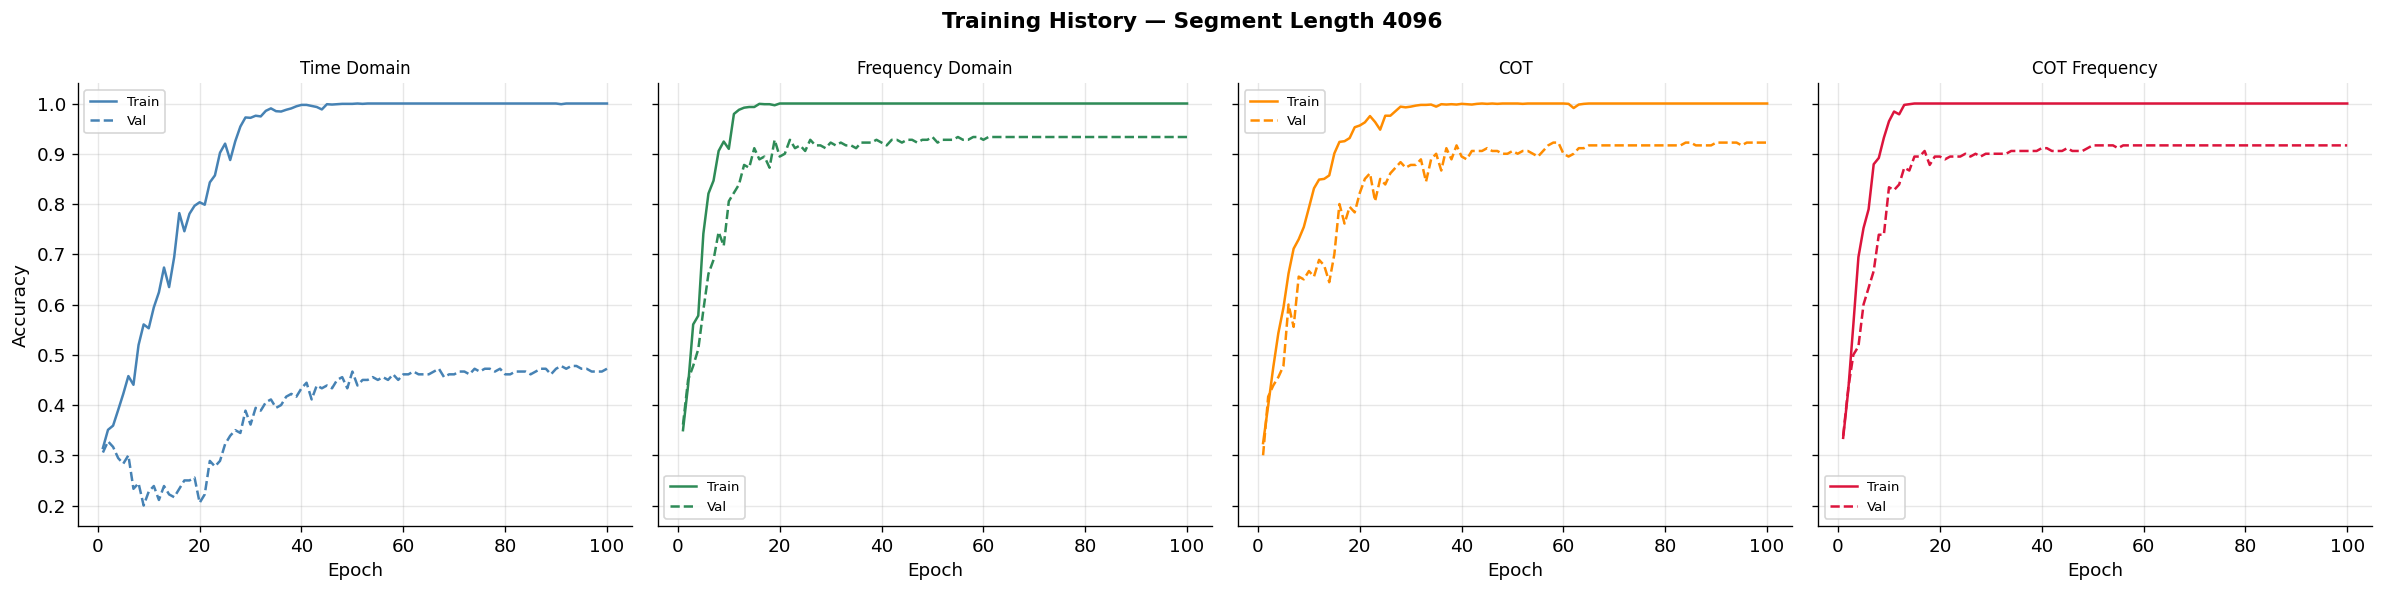

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for ax, domain in zip(axes, domain_names):
    histories = aggregated_metrics[domain][TARGET_SEGMENT]['histories']
    mean_val  = np.mean([h['val_accuracy'] for h in histories], axis=0)
    mean_tr   = np.mean([h['accuracy']     for h in histories], axis=0)
    epochs    = range(1, len(mean_val) + 1)

    ax.plot(epochs, mean_tr,  color=domain_colors[domain], lw=1.5, label='Train')
    ax.plot(epochs, mean_val, color=domain_colors[domain], lw=1.5, ls='--', label='Val')
    ax.set_title(domain, fontsize=10)
    ax.set_xlabel('Epoch')
    ax.legend(fontsize=8)

axes[0].set_ylabel('Accuracy')
plt.suptitle(f'Training History — Segment Length {TARGET_SEGMENT}',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Summary

| Domain | Best Accuracy (4096) | Notes |
|---|---|---|
| **Frequency** | **96% ± 4%** | Most stable across segment lengths |
| COT-Frequency | 93% ± 3% | Converges to frequency domain at 6144 |
| COT (Angular) | 90% ± 5% | Sharp improvement at 4096 |
| Time | 55% ± 11% | Poor throughout — fault features not learnable in raw time domain |

**Key observation:** Healthy vs. cracked tooth (10% severity) is the primary misclassification challenge across all domains. The CNN appears to learn additive noise as a fault feature rather than the underlying fault dynamics — confirmed by perfect confusion matrices when noise is removed. See **Notebook 3** for generalisation analysis.

**Reference:** Jing, L. et al. (2017). An adaptive multi-sensor data fusion method based on deep convolutional neural networks for fault diagnosis of planetary gearbox.